# Imports

In [1]:
import gym
import rubiks
import rubiks2

import random
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os 
import copy
import time

from collections import defaultdict

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from replay_memories import ReplayMemory, PrioritizedReplayMemory
from networks import DQN, DuelingDQN, DuelingDQNHER

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
print("Torch Version: ", torch.__version__)

Device:  cuda
Torch Version:  1.0.1.post2


# Epsilon

In [3]:
# Epsilon decay
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 1000

epsilon_by_exponential_step = lambda step_idx: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * step_idx / epsilon_decay)

epsilon_by_linear_step = lambda step_idx: epsilon_final + (epsilon_start-epsilon_final)*((epsilon_decay-step_idx)/epsilon_decay) if step_idx < epsilon_decay else epsilon_final

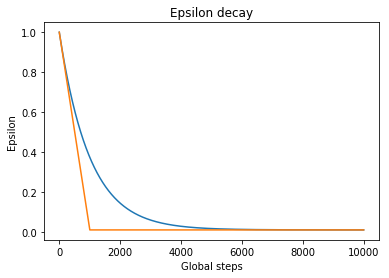

In [4]:
plt.figure
plt.title('Epsilon decay')
plt.xlabel('Global steps')
plt.ylabel('Epsilon')
plt.plot([epsilon_by_exponential_step(i) for i in range(10000)])
plt.plot([epsilon_by_linear_step(i) for i in range(10000)])

In [5]:
# Computes the q-values of an action in a state
def compute_q_val(model, state, action):
    qactions = model(state)
    return torch.gather(qactions,1,action.view(-1,1))

In [6]:
# Computes the target. When done, 0 is added to the reward as there is no next state.
def compute_target_dqn(model, reward, next_state, done, gamma):
    return reward + gamma * model(next_state).max(1)[0] * (1-done)

# Computes the target. When done, 0 is added to the reward as there is no next state. But now for Double DQN
def compute_target_ddqn(model, target_model, reward, next_state, done, gamma):
    a = model(next_state)
    return reward.view(-1,1) + gamma * torch.gather(target_model(next_state),1,model(next_state).max(1)[1].view(-1,1)) * (1-done).view(-1,1)

In [7]:
def train_dqn(online_network, target_network, memory, optimizer, batch_size, gamma, local_steps, doubleDQN):
    if len(memory) < batch_size:
        return None
    
    batch, indices, weights = memory.sample(batch_size, local_steps, device)

    state, action, reward, next_state, done = zip(*batch)
    
    state = torch.tensor(state, dtype=torch.float32, device=device)
    action = torch.tensor(action, dtype=torch.long, device=device)
    next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
    reward = torch.tensor(reward, dtype=torch.float32, device=device)
    done = torch.tensor(done, dtype=torch.float32, device=device)
    
    weights.to(device)

    optimizer.zero_grad()
    
    q_val = compute_q_val(online_network, state, action)

    with torch.no_grad():
# Vanilla
#         target = compute_target_dqn(q1, reward, next_state, done, gamma)
        if doubleDQN:
            target = compute_target_ddqn(online_network, target_network, reward, next_state, done, gamma)
        else:
            target = compute_target_dqn(target_network, reward, next_state, done, gamma)
#     loss = F.mse_loss(q_val, target)
    difference = (q_val - target.view(-1,1))
    
    # Weights is 1 for normal replay buffer so nothing changes
    # McAleer divides the loss by the number of moves of the scramble here. Might not make sense in non-MCTS setting
    loss = difference.pow(2) * weights
    loss = loss.mean()
    
    
    loss.backward()
    
    # Also taken from higgsfield
    memory.update_priorities(indices, difference.detach().squeeze().abs().cpu().numpy().tolist())
    optimizer.step()
    
    return loss.item()

In [8]:
def increase_capacity_keep_lr(network, capacity, optimizer, device):
    # Store old ids
    old_ids = [id(p) for p in network.parameters()]
    old_param_sizes = [p.size() for p in network.parameters()]

    network.increase_capacity(capacity)

    # Store new ids
    new_ids = [id(p) for p in network.parameters()]
    new_param_sizes = [p.size() for p in network.parameters()]

    # Store old state 
    opt_state_dict = optimizer.state_dict()
    for old_id, new_id, new_param_size, old_param_size in zip(old_ids, new_ids, new_param_sizes, old_param_sizes):
        # Store step, and exp_avgs
        step = opt_state_dict['state'][old_id]['step']
        old_exp_avg = opt_state_dict['state'][old_id]['exp_avg']
        old_exp_avg_sq = opt_state_dict['state'][old_id]['exp_avg_sq']
        old_max_exp_avg_sq = opt_state_dict['state'][old_id]['max_exp_avg_sq']

        exp_avg = torch.zeros(new_param_size)
        exp_avg_sq = torch.zeros(new_param_size)
        max_exp_avg_sq =  torch.zeros(new_param_size)
        # Extend exp_avgs to new shape depending on wether param is bias or weight
        if exp_avg.dim()>1:
            # Weights
            exp_avg[0:old_param_size[0],0:old_param_size[1]] = old_exp_avg
            exp_avg_sq[0:old_param_size[0],0:old_param_size[1]] = old_exp_avg_sq
            max_exp_avg_sq[0:old_param_size[0],0:old_param_size[1]] = old_max_exp_avg_sq
        else:
            # Biases/last layer
            exp_avg[0:old_param_size[0]] = old_exp_avg
            exp_avg_sq[0:old_param_size[0]] = old_exp_avg_sq
            max_exp_avg_sq[0:old_param_size[0]] = old_max_exp_avg_sq
        
        # Delete old id from state_dict and update new params and new id
        del opt_state_dict['state'][old_id]
        opt_state_dict['state'][new_id] = {
            'step': step,
            'exp_avg': exp_avg,
            'exp_avg_sq': exp_avg_sq.to(device),
            'max_exp_avg_sq' : max_exp_avg_sq.to(device)
        }
        opt_state_dict['param_groups'][0]['params'].remove(old_id)
        opt_state_dict['param_groups'][0]['params'].append(new_id)

    network.to(device)
    optimizer = optim.Adam(network.parameters(), amsgrad=True)
    optimizer.load_state_dict(opt_state_dict)
    
    return network, optimizer

In [9]:
def train_with_settings(architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, 
                        memoryCapacity, lr, amsgrad, epochs, batch_size, gamma, capacity_increase, 
                        threshold, evaluation_frequency, tau, curriculum, non_linearity,
                        verbose=False, load_path=None, save_path=None, seed=None):
    # If the directory does not exist, make one
    if save_path:
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
    
    # If a seed is set, set the seed for all sources of randomness
    if seed:
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
            
    # Difficulty the problem starts with
    difficulty = 0
    # The maximum number of tries the agent gets at the start
    max_tries_start = 1
    max_tries = max_tries_start
    # 3 is chosen because this allows the network to learn the difference between short and long paths from the beginning. Take for example a cube that has been scrambled as follows: U. The solution within 3 steps is eather U' (r=1) or U, U, U (r=-1)
    
    # Arrays to keep track of losses and accuracies over time
    losses = []
    accuracies = []
    
    # Global steps keeps track of the total number of optimisation steps
    global_steps = 0
    # Local steps keeps track of number of optimisation steps within a level
    local_steps = 0
    # Total time keeps track of how long the training process takes
    
    # Epsilon exponential decay
    epsilon_start = 1.0
    epsilon_final = 0.01
    # Duration of decay dependent on difficulty
#     epsilon_decay = 10000*(difficulty//12 + 1)
    epsilon_decay = 1000
    # Duration independent on dificulty
    epsilon_by_step = lambda step_idx: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * step_idx / epsilon_decay)
    
    # If a path with a model is provided certain variables are loaded
    if load_path:
        current_model = torch.load(load_path + 'model.pt')
        target_model = copy.deepcopy(current_model)
        max_tries = torch.load(load_path + 'max_tries')
        epsilon_decay = torch.load(load_path + 'epsilon_decay')
        global_steps = torch.load(load_path + 'global_steps')
        local_steps = torch.load(load_path + 'local_steps')
        difficulty = torch.load(load_path + 'difficulty')
    else:
        # n^2 per face, 6 faces, 6 colours one-hot encoded. 3x3x6x6=324, 2x2x6x6=144
        state_size = env.size**2 * 6**2
        
        # The number of output nodes is different for the 2x2x2. The move L is the same as the move R, except the orientation changes.
        output_nodes = 12
        if env.size == 2:
            output_nodes = 6
        
        # Initialising either a network with dueling architecture or regular network
        if duelingDQN:
            current_model = DuelingDQN(state_size, architecture, output_nodes, non_linearity)
            target_model = DuelingDQN(state_size, copy.copy(architecture), output_nodes, non_linearity)
        else:
            current_model = DQN(state_size, architecture, output_nodes, non_linearity)
            target_model = DQN(state_size, copy.copy(architecture), output_nodes, non_linearity)
            
    if torch.cuda.is_available():
        current_model.to('cuda')
        target_model.to('cuda')
    else:
        current_model.to('cpu')
        target_model.to('cpu')
    
    # Uses prioritized replay sampling when set to true, otherwise uniform replay sampling is used
    if prioritizedReplayMemory:
        memory = PrioritizedReplayMemory(memoryCapacity, alpha)
    else:
        memory = ReplayMemory(memoryCapacity)
    
    # Initialise optimiser
    optimizer = optim.Adam(current_model.parameters(), lr=lr, amsgrad=amsgrad)
    
    # This allows you to stop the training progress
    try:
        for epoch in range(epochs):
            epoch_losses = []
            # Different types of curricula decide what state to show the network next.
            if curriculum is 'Naive':
                state = env.curriculum_reset(difficulty)
            elif curriculum is 'Joe':
                p = np.random.rand()
                if p < 0.2:
                    state = env.curriculum_reset(np.random.randint(1, difficulty + 12))
                else:
                    state = env.curriculum_reset(difficulty)
            elif curriculum is 'Sutskever':
                p = np.random.rand()
                if p < 0.2:
                    state = env.reset(np.random.randint(1, 1000))
                else:
                    state = env.curriculum_reset(difficulty)
            elif curriculum is 'Mixed':
                state = env.curriculum_reset(np.random.randint(1,1000))
            else:
                state = env.reset(1000)

            done = 0
            tries = 0
            while tries < max_tries and not done:
                
                epsilon = epsilon_by_step(local_steps)
                action = current_model.act(state, epsilon, [0]*env.action_space.n, device)
                next_state, reward, done, info = env.step(action)
                memory.push((state, action, reward, next_state, done))

                state = next_state

                tries += 1
            
            loss = train_dqn(current_model, target_model, memory, optimizer, batch_size, gamma, local_steps, doubleDQN)

            if loss:
                epoch_losses.append(loss)
                
            global_steps += 1
            local_steps += 1
                
            if global_steps % tau == 0:
                target_model.load_state_dict(current_model.state_dict())
                if save_path:
                    torch.save(current_model, save_path + "model.pt")
                    torch.save(max_tries, save_path + "max_tries")
                    torch.save(epsilon_decay, save_path + "epsilon_decay")
                    torch.save(global_steps, save_path + "global_steps")
                    torch.save(local_steps, save_path + "local_steps")
                    torch.save(local_steps, save_path + "difficulty")
                    
            if global_steps % evaluation_frequency == 0 and curriculum is not None:
                total_done = 0
                for i in range(difficulty + 1):
                    # Here the agent is forced to evaluate its ability to solve certain last moves
                    hashes = defaultdict(list)
                    state = env.force_last_action_reset(i)
                    hashes[hash(state.tostring())] = [0]*env.action_space.n
                    done = 0
                    tries = 0
                    while tries < max_tries and not done:
                        mask = hashes[hash(state.tostring())]
                        action = current_model.act(state, 0, mask, device)
                        next_state, reward, done, info = env.step(action)
                        # memory.push((state, action, reward, next_state, done))
                        hstate = state.copy()
                        state = next_state
                        
                        h = hash(state.tostring())
                        if h in hashes.keys():
                            hashes[hash(hstate.tostring())][action] = -999
                        else:
                            hashes[h] = [0]*env.action_space.n
                        
                        total_done += done
                        tries += 1
                        
                # Here the agent evaluates the ability to solve puzzles that have the last move from a set of moves with the same difficulty
                for i in range(1000):
                    hashes = defaultdict(list)
                    state = env.curriculum_reset(difficulty)
                    hashes[hash(state.tostring())] = [0]*env.action_space.n
                    done = 0
                    tries = 0
                    while tries < max_tries and not done:
                        mask = hashes[hash(state.tostring())]
                        action = current_model.act(state, 0, mask, device)
                        next_state, reward, done, info = env.step(action)
                        # memory.push((state, action, reward, next_state, done))
                        hstate = state.copy()
                        state = next_state
                        
                        h = hash(state.tostring())
                        if h in hashes.keys():
                            hashes[hash(hstate.tostring())][action] = -999
                        else:
                            hashes[h] = [0]*env.action_space.n
                            
                        
                        total_done += done
                        tries += 1
                
                accuracy = total_done/(1000 + difficulty + 1)
                accuracies.append(accuracy)
                
                if accuracy >= threshold:
                    difficulty += 1
                    max_tries = difficulty // output_nodes + max_tries_start
                    local_steps = 0
                    
                    epsilon_start = 1.0
                    epsilon_final = 0.01
#                     epsilon_decay = 10000*(difficulty//output_nodes + 1)
                    epsilon_decay = 1000

                    epsilon_by_step = lambda step_idx: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * step_idx / epsilon_decay)
                
                if local_steps > 1000:
                    if capacity_increase:
                        local_steps = 0
                        capacity = [c(difficulty) for c in capacity_increase]

                        current_model, optimizer = increase_capacity_keep_lr(current_model, capacity, optimizer, device)
                        target_model.increase_capacity(capacity)

                        target_model.to(device)

                if verbose:
                    clear_output(True)
                    print("Epoch: ", epoch, "Global steps: ", global_steps)
                    print("Difficulty: ", difficulty, "Max tries:", max_tries)
                    print("Memory: ", len(memory), "epsilon: ", epsilon, "local steps: ", local_steps)
                    print("Accuracy: ", accuracy, "Threshold: ", threshold)
                    print(current_model)
                    
                losses.append(np.average(epoch_losses))
                
    except KeyboardInterrupt:
        pass
    
    if save_path:
        torch.save(current_model, save_path + "model.pt")
        torch.save(max_tries, save_path + "max_tries")
        torch.save(epsilon_decay, save_path + "epsilon_decay")
        torch.save(global_steps, save_path + "global_steps")
        torch.save(local_steps, save_path + "local_steps")
        torch.save(local_steps, save_path + "difficulty")
            
    return difficulty, accuracy

In [ ]:
epochs = 50000
experiments = []
# experiments.append(["Baseline3", [4096, 2048, 512], False, False, False, 0.7, 100000, 1e-3, False, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Naive', F.relu])
# experiments.append(["Mixed3", [4096, 2048, 512], False, False, False, 0.7, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Mixed', F.relu])
# experiments.append(["Joe3", [4096, 2048, 512], False, False, False, 0.7, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Joe', F.relu])
# experiments.append(["Sutskever3", [4096, 2048, 512], False, False, False, 0.7, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Prioritised0.53", [4096, 2048, 512], False, False, True, 0.5, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Prioritised0.73", [4096, 2048, 512], False, False, True, 0.7, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Prioritised0.93", [4096, 2048, 512], False, False, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Dueling3", [4096, 2048, 512], True, False, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Double3", [4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Linear_all3", [64, 32, 8], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, [lambda x: 48, lambda x: 24, lambda x: 6], 0.95, 100, 1000, 'Sutskever', F.relu])
# experiments.append(["Elu3", [4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, None, 0.95, 100, 1000, 'Sutskever', F.elu])
experiments.append(["Increasing_all", [8, 4, 1], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, [lambda x: 8, lambda x: 4, lambda x: 1], 0.95, 100, 1000, 'Sutskever', F.relu])
experiments.append(["Increasing_all", [64, 32, 8], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, [lambda x: 48, lambda x: 24, lambda x: 6], 0.95, 100, 1000, 'Sutskever', F.relu])
experiments.append(["Increasing_bottom", [64, 32, 512], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, [lambda x: 48, lambda x: 24, lambda x: 0], 0.95, 100, 1000, 'Sutskever', F.relu])
experiments.append(["Same", [4096, 2048, 512], True, True, True, 0.9, 100000, 1e-3, True, epochs, 128, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.95, 100, 1000, 'Sutskever', F.relu])

for experiment in experiments:
    architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, memoryCapacity, lr, amsgrad, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity = experiment[1:]

    env = rubiks2.RubiksEnv2(2, unsolved_reward = -1.0, seed= 420)

    train_with_settings(architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, memoryCapacity, lr, amsgrad, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity, save_path='models/'+experiment[0]+'/', seed=420, verbose=True)

In [ ]:
def superflip_test(model):
    eval_model = torch.load(model)
    eval_model.to(device)
    
    max_tries = 100
    solve_rate_per_difficulty = []
    average_tries_per_difficulty = []
    
    for i in range(14):
        solved = 0
        tries_solved = []
        cycles = 0
        start_states = defaultdict(list)
        
        for sequence in superflip_set:
            env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0)
            goal = env.get_observation()
            
            for j in range(i + 1):
                env.step(sequence[j])

            
            hashes = defaultdict(list)
            state = env.get_observation()
            
            # Remove duplicate starting states
            if hash(state.tostring()) in start_states.keys():
                continue
                
            hashes[hash(state.tostring())] = [0,0,0,0,0,0]
            done = 0
            tries = 0
            
            while not done and tries < max_tries:
                mask = hashes[hash(state.tostring())]
                
                action = eval_model.act(state, 0, mask, device)

                next_state, reward, done, info = env.step(action)

                hstate = state.copy()
                state = next_state

                tries += 1

                h = hash(state.tostring())
                if h in hashes.keys():
                    #hashes[hash(hstate.tostring())][action] = -999
                    cycles += 1
                else:
                    hashes[h] = [0,0,0,0,0,0]
            if done:
                solved += 1
            tries_solved.append(tries)   
            
        solve_rate_per_difficulty.append(solved / len(superflip_set))
        average_tries_per_difficulty.append(np.average(tries_solved))
        print('Level', i, 'accuracy:', solved / len(superflip_set))
        print(np.average(tries_solved), np.median(tries_solved))
        
    score = 0
    for target_tries, avg_tries in enumerate(average_tries_per_difficulty):
        score += ((target_tries + 1)/avg_tries)*solve_rate_per_difficulty[target_tries]
    score /= 14
    return solve_rate_per_difficulty, average_tries_per_difficulty, score
    

print(superflip_test('./models/Increasing_all/model.pt'))
print(superflip_test('./models/Increasing_bottom/model.pt'))
print(superflip_test('./models/Same/model.pt'))

In [ ]:
env = rubiks2.RubiksEnv2(2, unsolved_reward = -1.0, seed= 42)

# Which tests are failing?
difficulty = 42
max_tries = 16
current_model = torch.load('./models/Same/model.pt')
current_model.to(device)

total = 0
total_done = 0
for i in range(difficulty + 1):
    # Here the agent is forced to evaluate its ability to solve certain last moves
    hashes = defaultdict(list)
    state = env.force_last_action_reset(i)
    hashes[hash(state.tostring())] = [0]*env.action_space.n
    done = 0
    tries = 0
    while tries < max_tries and not done:
        mask = hashes[hash(state.tostring())]
        action = current_model.act(state, 0, mask, device)
        next_state, reward, done, info = env.step(action)

        hstate = state.copy()
        state = next_state

        h = hash(state.tostring())
        if h in hashes.keys():
            hashes[hash(hstate.tostring())][action] = -999
        else:
            hashes[h] = [0]*env.action_space.n

        total_done += done
        tries += 1
    total += 1
print(total_done)
total_done_2 = 0
# Here the agent evaluates the ability to solve puzzles that have the last move from a set of moves with the same difficulty
for i in range(1000):
    hashes = defaultdict(list)
    state = env.curriculum_reset(difficulty)
    
    hashes[hash(state.tostring())] = [0]*env.action_space.n
    done = 0
    tries = 0
    while tries < max_tries and not done:
        mask = hashes[hash(state.tostring())]
        action = current_model.act(state, 0, mask, device)
        q_val = current_model(torch.tensor(state, dtype=torch.float, device=device))
        next_state, reward, done, info = env.step(action)

        hstate = state.copy()
        state = next_state

        h = hash(state.tostring())
        if h in hashes.keys():
            hashes[hash(hstate.tostring())][action] = -999
        else:
            hashes[h] = [0]*env.action_space.n


        total_done += done
        total_done_2 += done
        tries += 1

    total+=1
    
    if not done:
        print(q_val
             )
        print([env.ACTION_MEANING_QUARTER_METRIC[scr] for scr in env.last_scramble])

print(total_done_2)
print(total_done/total)
accuracy = total_done/(1000 + difficulty + 1)
print(accuracy)

In [ ]:
superflip_set = [[4,0,5,1,5,4,5,5,1,3,2,1,3,3],
[0,5,1,1,0,0,1,5,0,2,2,4,4,5],
[1,2,2,3,3,5,0,4,0,2,4,3,5,0],
[1,0,5,0,4,3,3,1,3,1,0,2,3,2],
[5,0,5,1,5,1,5,1,5,1,5,3,1,5],
[3,5,3,2,4,2,4,5,1,0,4,3,5,0],
[2,4,2,0,0,2,4,5,3,1,0,0,4,4],
[5,0,5,4,3,2,3,4,3,2,4,2,2,1],
[2,0,4,0,4,0,4,0,4,5,3,5,4,5],
[2,4,2,4,3,2,2,1,3,5,4,4,2,3],
[4,4,0,4,0,5,4,5,0,0,1,3,1,2],
[0,4,0,5,1,1,0,2,2,3,2,3,5,5],
[0,1,0,4,2,4,2,4,0,2,4,5,4,3],
[2,3,2,2,1,5,1,5,3,5,1,5,5,4],
[4,0,5,4,0,4,3,2,3,5,1,0,5,0],
[2,3,1,2,1,5,3,2,3,1,2,1,2,2],
[5,4,0,5,3,1,2,4,2,1,5,1,0,2],
[2,4,0,1,3,4,0,0,2,2,4,0,5,4],
[5,1,2,3,4,3,5,3,2,4,2,0,2,0],
[1,2,0,4,2,3,1,3,1,0,4,5,0,1],
[4,2,1,5,0,2,3,5,4,2,3,1,5,3],
[2,3,4,5,1,5,0,4,2,3,1,2,1,3],
[0,5,1,3,2,4,0,0,4,0,4,0,5,0],
[5,1,2,3,5,1,3,4,2,4,5,5,0,2],
[0,4,3,5,1,0,5,0,2,3,4,4,3,1],
[3,3,4,2,4,5,1,3,3,5,0,2,0,0],
[5,3,1,3,5,1,0,0,1,0,1,5,4,4],
[2,0,1,5,1,3,1,2,4,3,2,4,0,2],
[1,0,4,3,5,3,5,1,5,0,4,3,2,1],
[3,1,0,2,2,0,5,3,1,3,4,5,1,3],
[1,3,5,4,0,2,2,3,1,3,4,0,2,3],
[5,3,1,1,3,2,1,5,0,5,1,1,2,3],
[4,3,2,1,3,5,1,5,4,4,2,4,3,4],
[4,4,3,5,0,5,5,3,1,3,2,4,5,1],
[4,4,5,0,5,3,2,1,1,3,1,0,1,1],
[5,1,2,3,2,1,2,3,3,4,3,2,4,4],
[3,3,1,2,4,0,4,2,4,3,3,4,2,2],
[3,5,0,5,5,3,1,3,2,3,2,1,5,4],
[3,4,2,2,4,5,1,5,0,5,1,2,4,5],
[4,2,4,2,2,1,0,4,0,1,2,4,5,4],
[4,0,4,0,5,1,2,1,3,2,1,0,5,3],
[1,2,2,3,3,4,0,2,1,0,4,0,5,0],
[2,3,3,5,1,3,2,3,1,5,4,4,2,2],
[1,2,2,4,2,4,0,4,3,3,5,5,4,0],
[4,0,4,4,5,4,4,2,4,0,5,5,0,4],
[5,1,3,2,1,3,2,1,2,1,0,5,4,3],
[4,4,2,0,1,1,5,3,1,3,2,0,4,5],
[0,1,5,3,2,1,5,3,2,4,0,2,4,2],
[1,3,2,3,5,0,1,5,0,1,3,4,0,0],
[1,2,1,3,1,5,1,3,1,5,4,3,5,5],
[3,1,3,4,2,3,4,3,4,4,0,2,3,1],
[5,1,2,2,1,5,0,5,5,3,5,5,1,3],
[5,3,2,4,0,5,4,3,2,4,5,3,2,3],
[1,2,1,3,2,4,0,4,2,0,1,2,3,5],
[3,5,5,3,5,0,5,4,2,2,4,2,3,2],
[4,5,1,5,4,2,1,1,3,5,1,2,3,2],
[3,5,1,3,3,1,2,3,2,3,1,2,4,2],
[2,0,1,3,2,3,1,3,2,4,5,0,4,4],
[1,2,4,2,0,0,4,3,1,3,2,2,0,0],
[2,3,3,5,4,0,4,0,4,5,4,5,4,0],
[2,1,3,2,2,3,1,3,2,0,4,3,3,2],
[4,4,5,4,2,2,4,0,5,0,1,3,2,3],
[3,2,4,4,3,5,0,4,0,4,5,5,1,0],
[3,4,2,4,2,4,2,4,0,2,0,2,0,1],
[4,5,3,4,0,4,5,0,1,3,1,2,1,2],
[3,5,5,1,3,2,4,3,3,4,3,2,1,1],
[3,4,4,3,1,2,3,1,5,0,5,4,5,0],
[0,2,0,1,1,5,0,1,3,1,3,5,1,5],
[3,1,5,1,2,0,5,3,1,5,5,4,2,4],
[2,4,4,5,3,1,3,5,1,2,4,3,3,4],
[3,1,3,4,3,5,1,5,0,5,4,4,0,4],
[2,3,1,5,3,1,5,1,2,1,5,5,1,2],
[3,3,4,0,1,5,3,2,3,3,2,3,1,3],
[1,5,3,1,2,0,2,0,4,0,5,3,5,4],
[0,1,1,5,0,4,5,0,2,4,5,1,5,4],
[3,2,4,2,1,5,0,0,1,2,4,5,4,0],
[0,4,0,5,0,4,2,4,2,2,4,2,3,2],
[5,0,5,5,4,3,5,1,5,1,5,3,1,5],
[0,5,4,5,0,4,0,4,0,1,5,3,3,2],
[5,5,3,2,3,1,0,1,5,1,1,3,5,5],
[0,5,1,0,5,3,3,5,1,2,0,5,5,4],
[0,4,5,5,1,5,0,5,3,1,5,4,3,1],
[5,1,0,4,2,2,0,1,2,2,1,5,1,1],
[4,4,0,2,3,1,5,1,3,4,4,3,1,1],
[0,5,1,5,1,2,2,0,0,1,1,2,4,2],
[2,0,2,2,3,1,0,4,0,2,2,3,1,2],
[4,0,2,3,1,5,3,1,5,0,2,4,0,4],
[1,3,5,4,0,2,4,2,4,3,5,4,4,0],
[5,4,3,5,1,5,1,1,2,4,2,0,4,3],
[1,5,4,0,5,4,3,1,2,3,4,4,5,3],
[0,2,3,2,0,2,3,1,3,1,5,1,0,0],
[5,4,3,2,3,2,0,5,0,4,4,2,0,2],
[2,1,5,1,2,4,4,0,2,1,2,4,3,3],
[2,3,2,2,1,0,1,3,5,1,2,1,1,2],
[5,0,4,3,1,3,4,0,1,5,1,0,1,3],
[5,5,0,0,2,4,2,1,5,0,4,3,4,4],
[1,0,5,0,1,2,4,5,1,3,5,0,2,3],
[4,4,2,0,5,1,5,0,5,1,1,5,3,3],
[0,2,4,5,5,4,5,3,1,3,3,2,3,1],
[4,0,5,5,1,3,5,1,3,1,3,5,0,4],
[0,2,2,4,2,4,3,2,2,3,3,1,0,2],
[5,1,3,1,2,0,4,2,2,0,4,4,3,1],
[1,2,1,1,0,5,0,5,1,2,0,5,3,5],
[3,1,5,1,0,4,3,1,0,2,4,5,5,0],
[5,5,1,0,4,2,3,2,4,5,5,1,2,2],
[2,3,2,3,1,5,0,1,2,3,3,5,1,3],
[4,2,4,4,0,4,5,0,5,0,4,3,1,3],
[1,3,1,3,4,0,2,2,0,1,0,4,2,2],
[3,1,5,1,5,0,4,3,4,5,5,1,3,1],
[5,4,0,1,5,0,2,4,0,5,1,1,2,3],
[2,1,0,4,5,0,4,2,3,2,4,2,1,0],
[0,4,2,1,3,2,4,0,2,1,5,5,3,1],
[0,5,3,4,4,3,2,0,5,0,4,5,4,3],
[2,3,2,3,5,0,1,5,4,5,0,5,5,4],
[4,0,5,5,0,2,0,4,2,0,4,5,0,4],
[4,0,4,5,1,5,0,1,2,3,2,1,1,3],
[3,4,4,2,1,5,1,3,2,4,4,5,1,1],
[0,5,3,3,2,0,2,4,0,4,0,5,1,2],
[2,1,5,1,3,1,0,5,0,2,2,3,3,1],
[0,4,5,5,0,4,3,1,3,2,3,2,1,3],
[1,0,0,5,0,5,1,3,3,1,2,3,2,2],
[4,5,1,3,4,2,0,5,4,2,3,5,5,1],
[3,2,1,5,3,2,3,4,5,4,4,2,1,3],
[3,5,5,1,3,5,3,2,2,1,3,5,1,2],
[3,4,2,1,1,2,3,4,3,5,3,5,5,1],
[0,4,0,5,0,4,3,2,3,1,1,0,2,1],
[2,1,5,0,4,3,4,2,3,3,1,0,0,1],
[4,4,3,2,4,2,0,2,0,0,5,0,5,4],
[2,0,4,0,4,5,4,2,0,0,2,4,5,0],
[1,2,3,1,3,2,4,4,5,3,4,3,5,0],
[4,2,3,5,3,2,3,5,3,1,2,3,5,0],
[3,4,0,4,2,3,1,0,5,4,4,0,2,2],
[4,2,2,4,0,2,3,1,5,1,1,0,4,4],
[1,2,0,2,0,4,0,5,3,1,3,4,0,4],
[0,1,3,1,1,5,0,1,3,2,4,4,0,5],
[2,3,1,3,1,2,3,4,4,2,4,4,3,1],
[4,0,5,5,4,5,1,5,0,4,5,3,1,0],
[2,4,2,3,2,0,5,4,4,0,5,5,4,0],
[5,3,1,5,0,2,1,3,4,2,1,5,1,3],
[4,4,0,5,1,3,1,2,1,5,0,1,0,5],
[5,1,1,5,1,2,3,1,3,5,5,1,0,0],
[1,5,3,2,3,5,0,1,2,2,1,5,1,3],
[5,4,0,0,2,1,0,4,2,3,1,3,1,2],
[0,1,1,0,4,3,5,0,4,5,3,1,5,3],
[5,4,2,4,2,3,2,1,0,0,4,5,0,0],
[4,0,5,0,5,0,2,0,4,3,2,3,4,5],
[2,0,5,0,4,4,5,4,2,4,0,0,4,4],
[0,4,2,3,1,3,4,0,2,2,4,2,2,0],
[2,3,4,5,0,1,2,3,2,1,3,5,3,3],
[4,2,3,4,3,1,1,3,4,3,4,2,0,4],
[0,4,3,2,4,5,5,1,3,2,1,3,5,5],
[5,1,0,1,0,5,1,5,4,2,2,4,3,4],
[5,5,4,5,4,0,1,5,3,2,1,3,4,4],
[4,4,0,5,3,1,5,0,1,3,3,4,2,4],
[5,3,2,1,5,1,3,4,5,0,4,4,5,5],
[5,0,5,0,5,1,5,5,0,4,3,4,0,2],
[0,2,3,4,5,1,5,1,1,3,2,0,4,0],
[5,3,2,3,5,0,1,5,4,2,4,3,3,2],
[2,4,4,0,4,0,4,2,3,1,2,0,4,5],
[5,5,1,3,5,4,3,2,1,5,4,2,3,4],
[5,5,4,2,3,1,5,1,2,0,4,3,4,5],
[4,2,3,5,3,2,3,5,3,1,2,3,5,3],
[1,3,2,4,5,3,3,1,0,2,3,1,0,2],
[3,2,4,4,0,5,3,2,0,2,2,1,1,3],
[1,0,4,2,1,3,2,2,3,4,5,1,5,5],
[3,1,0,4,2,2,4,3,4,0,4,2,2,4],
[2,3,1,2,2,4,2,1,5,0,5,1,5,3],
[1,5,0,5,3,4,5,4,2,3,5,1,3,2],
[0,4,0,4,0,4,5,0,4,5,0,1,2,2],
[3,2,4,4,3,4,2,4,5,1,0,0,5,5],
[1,3,4,4,5,1,3,5,0,4,2,3,5,3],
[3,3,1,5,1,5,1,2,1,3,5,0,5,3],
[3,1,0,4,2,3,2,0,2,4,4,3,2,4],
[4,2,3,1,1,2,0,2,2,3,1,3,1,5],
[5,3,1,5,1,5,3,4,4,2,4,5,4,2],
[5,1,2,3,1,1,2,0,5,5,0,5,1,1],
[2,4,0,1,3,1,3,2,0,1,1,0,2,2],
[4,0,5,5,0,2,2,1,0,1,0,4,5,5],
[3,2,1,5,0,5,0,1,5,1,2,0,4,0],
[2,4,2,3,5,0,2,2,1,5,3,2,3,1],
[3,3,5,1,2,3,3,5,1,3,4,2,2,3],
[5,1,3,4,3,5,3,1,2,4,4,0,2,4],
[4,4,3,4,5,0,2,3,2,3,4,2,1,2],
[2,3,3,2,3,3,1,5,4,5,0,4,0,1],
[4,2,3,1,3,5,4,0,1,3,4,2,1,1],
[5,0,2,4,5,3,3,1,3,5,4,0,1,1],
[3,4,0,1,5,0,0,1,2,4,0,4,4,3],
[2,3,5,4,2,4,0,2,0,5,1,1,5,5],
[4,2,3,5,1,3,2,1,5,4,3,1,5,3],
[5,1,3,5,4,2,3,4,5,1,2,3,4,0],
[5,5,3,2,3,4,0,4,3,1,0,5,4,5],
[3,5,0,4,3,5,5,1,3,2,0,2,4,2],
[3,1,2,0,5,1,0,2,3,5,1,0,4,5],
[2,0,5,3,3,5,1,3,4,2,3,5,3,4],
[1,0,5,1,2,3,1,1,2,4,4,2,2,0],
[1,5,1,5,1,3,5,0,4,3,1,5,4,2],
[0,1,3,3,2,3,4,5,1,5,1,0,0,4],
[1,3,4,0,5,3,2,0,1,3,2,4,0,2],
[3,2,3,2,2,1,2,1,3,1,3,1,2,4],
[4,2,4,0,2,0,4,3,5,0,4,0,4,5],
[3,1,2,2,4,0,4,2,3,1,0,1,5,1],
[0,1,1,5,1,3,1,5,4,3,1,5,3,3],
[3,3,2,2,3,1,2,0,4,2,3,4,3,1],
[4,4,0,4,3,1,2,1,5,5,4,2,0,2],
[2,4,0,0,1,2,4,2,3,1,2,4,4,3],
[3,1,0,4,2,2,4,3,4,0,5,5,0,5],
[5,3,1,1,0,5,1,2,1,0,2,2,1,2],
[5,3,4,0,4,3,3,5,1,2,3,2,4,3],
[2,3,5,1,3,3,5,4,2,2,4,2,0,0],
[0,5,1,3,2,3,2,4,3,1,1,2,3,4],
[4,2,4,4,3,5,0,4,3,2,3,3,1,1],
[2,4,0,0,4,3,3,5,3,5,4,0,5,5],
[2,3,2,2,1,5,4,2,3,4,5,3,2,4],
[2,1,3,1,1,0,4,2,3,1,2,0,5,1],
[0,5,0,5,1,3,2,4,5,4,2,1,3,5],
[5,1,0,4,3,2,4,2,4,5,5,3,2,4],
[5,0,4,0,4,5,0,2,0,4,0,5,0,1],
[2,3,2,4,3,1,5,4,2,3,5,0,4,2],
[1,5,0,5,1,2,3,2,4,0,0,4,3,4],
[2,3,4,0,2,2,1,3,2,4,2,4,2,4],
[2,0,1,5,0,0,4,2,4,3,2,0,0,1],
[5,5,3,1,3,3,5,0,2,3,2,4,0,4],
[0,2,2,4,2,3,2,4,4,2,1,3,4,4],
[2,0,4,2,2,1,3,2,3,2,4,3,1,0],
[3,1,2,3,5,1,5,5,3,3,1,0,4,0],
[3,5,0,1,1,3,2,3,1,5,0,2,0,4],
[4,5,1,3,2,2,1,1,3,1,5,0,5,3],
[5,0,4,2,3,2,4,3,2,3,5,0,5,4],
[3,2,1,2,4,2,1,2,4,4,0,2,4,3],
[3,5,5,4,4,2,3,2,0,5,4,4,5,0],
[1,0,2,4,2,0,0,5,0,5,1,0,4,2],
[4,2,4,3,2,4,2,1,0,5,1,2,2,3],
[2,1,0,0,5,0,1,3,2,3,1,1,2,0],
[4,2,2,1,2,4,2,3,2,0,2,1,2,4],
[2,3,5,4,4,0,1,2,1,5,0,0,1,1],
[5,5,1,0,2,3,1,5,5,4,0,5,3,4],
[3,1,5,4,2,3,2,0,2,4,0,0,4,0],
[3,2,3,4,0,1,3,4,5,0,1,1,5,1],
[5,3,1,2,0,4,0,2,4,2,0,1,2,2],
[2,4,3,4,2,4,0,4,2,3,1,0,1,5],
[3,3,1,2,2,1,0,5,1,3,1,0,5,0],
[4,2,1,5,0,4,4,2,2,0,5,3,2,4],
[0,5,1,2,2,1,0,1,3,5,0,4,0,1],
[2,4,5,4,0,1,1,5,3,1,3,2,3,2],
[5,0,4,0,4,5,4,2,1,0,4,0,4,4],
[4,4,5,4,2,2,0,1,3,1,3,5,1,2],
[2,1,3,5,0,2,3,4,5,1,3,4,5,1],
[0,2,3,5,5,3,1,3,4,0,5,3,5,4],
[4,3,1,3,2,4,0,4,2,4,5,0,1,1],
[0,5,3,4,4,2,4,2,3,5,1,1,0,1],
[3,4,4,2,4,0,1,0,0,1,0,0,2,1],
[4,3,2,1,5,3,1,5,3,5,3,4,0,1],
[2,4,2,3,1,0,2,3,3,4,3,4,5,1],
[2,4,2,0,1,5,1,3,5,1,2,3,3,5],
[3,4,0,4,4,0,4,2,0,1,1,0,5,5],
[5,5,1,0,5,0,4,3,1,3,2,2,3,3],
[3,1,5,3,1,5,1,3,5,1,5,1,1,2],
[4,2,3,1,5,5,0,5,0,2,1,5,1,1],
[5,4,2,1,5,0,4,0,5,4,5,5,4,5],
[0,5,4,2,0,4,2,1,2,0,0,5,4,2],
[5,0,0,2,2,1,5,4,2,4,4,3,3,4],
[3,1,0,5,1,5,4,2,4,5,4,3,5,1],
[4,4,5,0,4,5,3,3,5,1,0,4,2,1],
[4,2,3,4,0,2,4,2,2,4,0,5,4,4],
[2,4,5,4,0,1,5,1,5,3,5,0,0,1],
[3,4,2,4,0,1,2,4,4,3,1,0,1,2],
[5,1,2,2,3,5,0,5,4,0,5,5,4,4],
[3,2,3,1,2,2,4,5,3,3,1,3,1,5],
[3,4,3,2,4,0,4,0,1,2,1,5,0,5],
[1,5,4,3,1,5,3,2,0,5,0,2,3,1],
[4,5,1,3,5,0,4,2,3,2,0,2,4,4],
[1,3,2,4,0,2,3,5,4,2,3,2,4,4],
[2,0,1,1,5,0,2,3,2,4,2,2,0,2],
[3,1,5,0,4,2,4,2,1,0,4,2,1,1],
[3,4,2,4,0,5,3,1,1,3,1,2,4,2],
[4,4,5,3,5,1,2,3,1,2,2,4,2,1]]

In [10]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [12]:
def generate_zero():
    return random.uniform(0, 49) / 100

def generate_one():
    return random.uniform(50, 100) / 100

def generate_both(num_data_points, p):
    Xs, Ys = [], []
    for _ in range(num_data_points):
        if random.random() < p:
            Xs.append([generate_zero(), generate_zero(), 0]); Ys.append([0])
            # or(1, 0) -> 1
            Xs.append([generate_one(), generate_zero(), 0]); Ys.append([1])
            # or(0, 1) -> 1
            Xs.append([generate_zero(), generate_one(), 0]); Ys.append([1])
            # or(1, 1) -> 1
            Xs.append([generate_one(), generate_one(), 0]); Ys.append([1])
        else:
            # xor(0, 0) -> 0
            Xs.append([generate_zero(), generate_zero(), 1]); Ys.append([0])
            # xor(1, 0) -> 1
            Xs.append([generate_one(), generate_zero(), 1]); Ys.append([1])
            # xor(0, 1) -> 1
            Xs.append([generate_zero(), generate_one(), 1]); Ys.append([1])
            # xor(1, 1) -> 0
            Xs.append([generate_one(), generate_one(), 1]); Ys.append([0])
    return Xs, Ys

def generate_or_XY(num_data_points):
    Xs, Ys = [], []
    for _ in range(num_data_points):
        # or(0, 0) -> 0 
        Xs.append([generate_zero(), generate_zero(), 0]); Ys.append([0])
        # or(1, 0) -> 1
        Xs.append([generate_one(), generate_zero(), 0]); Ys.append([1])
        # or(0, 1) -> 1
        Xs.append([generate_zero(), generate_one(), 0]); Ys.append([1])
        # or(1, 1) -> 1
        Xs.append([generate_one(), generate_one(), 0]); Ys.append([1])
    return Xs, Ys

def generate_xor_XY(num_data_points):
    Xs, Ys = [], []
    for _ in range(num_data_points):
        # xor(0, 0) -> 0 
        Xs.append([generate_zero(), generate_zero(), 1]); Ys.append([0])
        # xor(1, 0) -> 1
        Xs.append([generate_one(), generate_zero(), 1]); Ys.append([1])
        # xor(0, 1) -> 1
        Xs.append([generate_zero(), generate_one(), 1]); Ys.append([1])
        # xor(1, 1) -> 0
        Xs.append([generate_one(), generate_one(), 1]); Ys.append([0])
    return Xs, Ys

In [13]:
def xor_experiments(initial_capacity, train_or, capacity):
    lowest_loss = 0
    lowest_settings = []    
    losses_xor = []
    losses_or = []
    for seed in range(100):
        # Set seeds
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Initialisation network
        network = DQN(3,initial_capacity.copy(),1,F.relu)
        # optimizer = optim.Adam(network.parameters(), amsgrad=False)
        optimizer = optim.Adam(network.parameters(), amsgrad=True)
        criterion = nn.MSELoss()
        
        if train_or:
            for i in range(500):
                optimizer.zero_grad()

                Xs, Ys = generate_both(25,0.1)
                    
                Xs = torch.tensor(Xs)
                Ys = torch.tensor(Ys, dtype=torch.float)

                prediction = network(Xs)
                loss = criterion(prediction, Ys)

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    # Evaluation
                    prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
                    Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
                    loss = 1.0/(1.0+criterion(prediction, Ys))

                if loss>0.95:
                    break
        
        
        if capacity is not None:
            network, optimizer = increase_capacity_keep_lr(network, capacity, optimizer, 'cpu')
        
        
        iters = 500
        if not train_or:
            iters * 2
            
        for i in range(iters):
            optimizer.zero_grad()
            
            # Uniform syllabus 20% of the time
            Xs, Ys = generate_both(25,0.9)
                
            Xs = torch.tensor(Xs)
            Ys = torch.tensor(Ys, dtype=torch.float)

            prediction = network(Xs)
            loss = criterion(prediction, Ys)

            loss.backward()
            optimizer.step()
        
        average_loss = 0
        
        with torch.no_grad():
            # Test or
            prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
            Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
            loss = 1.0/(1.0+criterion(prediction, Ys))
        
        average_loss += loss.item()
        losses_or.append(loss.item())

        with torch.no_grad():
            # Test xor
            prediction = network(torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float))
            Ys = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)
            loss = 1.0/(1.0+criterion(prediction, Ys))
        
        average_loss += loss.item()
        average_loss /= 2
        losses_xor.append(loss.item())
        
        if average_loss > lowest_loss:
            lowest_loss = copy.copy(average_loss)
            lowest_settings = [average_loss, losses_or[-1], losses_xor[-1], seed, initial_capacity, train_or, capacity]
        
        if loss>0.95:
            break
        
    # Print statistics
    print(initial_capacity, train_or, capacity)
    print('Average loss or: ', np.average(losses_or))
    print('Average loss xor: ', np.average(losses_xor))
    print('Average loss: ', (np.average(losses_or) +  np.average(losses_xor))/2)
    print(lowest_settings)
    
xor_experiments([2],False, None)
xor_experiments([2], True, None)
xor_experiments([1], True, [1])

xor_experiments([3],False,None)
xor_experiments([3], True, None)
xor_experiments([2], True, [1])
xor_experiments([1], True, [2])

xor_experiments([4],False,None)
xor_experiments([4], True, None)
xor_experiments([1], True, [3])
xor_experiments([2], True, [2])
xor_experiments([3], True, [1])

[2] False None
Average loss or:  0.8620795825123787
Average loss xor:  0.7334545511007309
Average loss:  0.7977670668065548
[0.8937549889087677, 0.9609179496765137, 0.8265920281410217, 70, [2], False, None]
[2] True None
Average loss or:  0.9075014442205429
Average loss xor:  0.7316605460643768
Average loss:  0.8195809951424599
[0.9125300049781799, 0.9765307307243347, 0.8485292792320251, 88, [2], True, None]


KeyboardInterrupt: 

In [ ]:
initial_capacity = [4]
capacity = None
train_or = True
# Set seeds
random.seed(99)
np.random.seed(99)
torch.manual_seed(99)

# Initialisation network
network = DQN(3,initial_capacity.copy(),1,F.relu)
# optimizer = optim.Adam(network.parameters(), amsgrad=False)
optimizer = optim.Adam(network.parameters(), amsgrad=True)
criterion = nn.MSELoss()

if train_or:
    for i in range(1000):
        optimizer.zero_grad()

        if np.random.rand() < 0.2:
            if np.random.rand() < 0.5:
                Xs, Ys = generate_or_XY(1)
            else:
                Xs, Ys = generate_xor_XY(1)
        else:
            Xs, Ys = generate_or_XY(1)

        Xs = torch.tensor(Xs)
        Ys = torch.tensor(Ys, dtype=torch.float)

        prediction = network(Xs)
        loss = criterion(prediction, Ys)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # Evaluation
            prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
            Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
            loss = criterion(prediction, Ys)

        if loss<0.05:
            break


    nw_before = copy.deepcopy(network) 
if capacity is not None:
    network, optimizer = increase_capacity_keep_lr(network, capacity, optimizer, 'cpu')

nw_after_increase = copy.deepcopy(network)

iters = 1000
if not train_or:
    iters * 2

for i in range(iters):
    optimizer.zero_grad()

    # Uniform syllabus 20% of the time
    if np.random.rand() < 0.2:
        if np.random.rand() < 0.5:
            Xs, Ys = generate_or_XY(1)
        else:
            Xs, Ys = generate_or_XY(1)
    else:
        Xs, Ys = generate_xor_XY(1)

    Xs = torch.tensor(Xs)
    Ys = torch.tensor(Ys, dtype=torch.float)

    prediction = network(Xs)
    loss = criterion(prediction, Ys)

    loss.backward()
    optimizer.step()

with torch.no_grad():
    # Test or
    prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
    Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
    loss = criterion(prediction, Ys)

with torch.no_grad():
    # Test xor
    prediction = network(torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float))
    Ys = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)
    loss = criterion(prediction, Ys)

In [ ]:
# Visualising specific weights, biases, and activations
from matplotlib import colors

def show_mat_label(data, data2=None):
    data_list = []
    if data2 is not None:
        vmin = data.min()
        vmax = data.max()

        fig, axs = plt.subplots(3,1)
        data_list.append(axs[0].matshow(data))

        vmin = min(vmin,data2.min())
        vmax = max(vmax,data2.max())
        
        data_list.append(axs[1].matshow(data2))
        axs[1].get_xaxis().set_visible(False)

        vmin = min(vmin,np.abs(data-data2).min())
        vmax = max(vmax,np.abs(data-data2).max())
        data_list.append(axs[2].matshow(np.abs(data-data2)))
        axs[2].get_xaxis().set_visible(False)
        
        norm = colors.Normalize(vmin=0, vmax=1)
        
        fig.colorbar(data_list[0], ax=axs)
        
        for d in data_list:
            d.set_norm(norm)
    else:
        fig, axs = plt.subplots()
        cax = axs.matshow(data)
        if data.shape[0]==1:
            axs.get_yaxis().set_visible(False)
        fig.colorbar(cax)
    
    plt.show()

x = torch.tensor([[0,0,1]],dtype=torch.float)

weights0 = network.layers[0].weight.data.numpy()
bias0 = np.array([network.layers[0].bias.data.numpy()])

weights1 = network.layers[1].weight.data.numpy()
bias1 = np.array([network.layers[1].bias.data.numpy()])

x = torch.tensor([[1,1,0]],dtype=torch.float)
print(network(x))
x2 = torch.tensor([[1,1,1]],dtype=torch.float)
print(network(x2))

print('Weights')
show_mat_label(weights0)
print('Bias')
show_mat_label(bias0)
print('Activations')
show_mat_label(F.relu(network.layers[0](x)).data.numpy(),F.relu(network.layers[0](x2)).data.numpy())
print(np.abs(F.relu(network.layers[0](x)).data.numpy()-F.relu(network.layers[0](x2)).data.numpy()))

x = F.relu(network.layers[0](x))
x2 = F.relu(network.layers[0](x2))

print('Weights')
show_mat_label(weights1)
print('Bias')
show_mat_label(bias1)
print('Activations')

show_mat_label(network.layers[1](x).data.numpy(),network.layers[1](x2).data.numpy())

In [ ]:
def weight_change(initial_capacity, capacity, train_or):
    common = []
    new = []
    total = []
    common_bias = []
    new_bias = []

    for seed in range(100):  
        # Set seeds
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Initialisation network
        network = DQN(3,initial_capacity.copy(),1,F.relu)
        # optimizer = optim.Adam(network.parameters(), amsgrad=False)
        optimizer = optim.Adam(network.parameters(), amsgrad=True)
        criterion = nn.MSELoss()

        if train_or:
            for i in range(1000):
                optimizer.zero_grad()

                if np.random.rand() < 0.2:
                    if np.random.rand() < 0.5:
                        Xs, Ys = generate_or_XY(1)
                    else:
                        Xs, Ys = generate_xor_XY(1)
                else:
                    Xs, Ys = generate_or_XY(1)

                Xs = torch.tensor(Xs)
                Ys = torch.tensor(Ys, dtype=torch.float)

                prediction = network(Xs)
                loss = criterion(prediction, Ys)

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    # Evaluation
                    prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
                    Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
                    loss = criterion(prediction, Ys)

                if loss<0.05:
                    break


            nw_before = copy.deepcopy(network) 
        if capacity is not None:
            network, optimizer = increase_capacity_keep_lr(network, capacity, optimizer, 'cpu')

        nw_after_increase = copy.deepcopy(network)

        iters = 1000
        if not train_or:
            iters * 2

        for i in range(iters):
            optimizer.zero_grad()

            # Uniform syllabus 20% of the time
            if np.random.rand() < 0.2:
                if np.random.rand() < 0.5:
                    Xs, Ys = generate_or_XY(1)
                else:
                    Xs, Ys = generate_or_XY(1)
            else:
                Xs, Ys = generate_xor_XY(1)

            Xs = torch.tensor(Xs)
            Ys = torch.tensor(Ys, dtype=torch.float)

            prediction = network(Xs)
            loss = criterion(prediction, Ys)

            loss.backward()
            optimizer.step()

        with torch.no_grad():
            # Test or
            prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
            Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
            loss = criterion(prediction, Ys)

        with torch.no_grad():
            # Test xor
            prediction = network(torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float))
            Ys = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)
            loss = criterion(prediction, Ys)

        common.append([torch.abs(nw_after_increase.layers[0].weight[0]-network.layers[0].weight[0]).mean().data.numpy(), torch.abs(nw_after_increase.layers[1].weight[0][0]-network.layers[1].weight[0][0]).mean().data.numpy()])
        new.append([torch.abs(nw_after_increase.layers[0].weight[1:]-network.layers[0].weight[1:]).mean().data.numpy(), torch.abs(nw_after_increase.layers[1].weight[0][1:]-network.layers[1].weight[0][1:]).mean().data.numpy()])
        total.append([torch.abs(nw_after_increase.layers[0].weight[:]-network.layers[0].weight[:]).mean().data.numpy(), torch.abs(nw_after_increase.layers[1].weight[0][:]-network.layers[1].weight[0][:]).mean().data.numpy()])
        
        common_bias.append([torch.abs(nw_after_increase.layers[0].bias[0]-network.layers[0].bias[0]).mean().data.numpy(), torch.abs(nw_after_increase.layers[1].bias[0]-network.layers[1].bias[0]).mean().data.numpy()])
        new_bias.append([torch.abs(nw_after_increase.layers[0].bias[1:]-network.layers[0].bias[1:]).mean().data.numpy(), torch.abs(nw_after_increase.layers[1].bias[0]-network.layers[1].bias[0]).mean().data.numpy()])
        
    print("Common layer 0:\t", np.average(np.array(common)[:,0]))
    print("New layer 0:\t", np.average(np.array(new)[:,0]))
    print("Total layer 0:\t", np.average(np.array(total)[:,0]))
    print("Common bias 0:\t", np.average(np.array(common_bias)[:,0]))
    print("New bias 0:\t", np.average(np.array(new_bias)[:,0]))
    
    print("Common layer 1:\t", np.average(np.array(common)[:,1]))
    print("New layer 1:\t", np.average(np.array(new)[:,1]))
    print("Total layer 1:\t", np.average(np.array(total)[:,1]))
    print("Common bias 1:\t", np.average(np.array(common_bias)[:,1]))
    print("New bias 1:\t", np.average(np.array(new_bias)[:,1]))

In [496]:
initial_capacity = [4]
capacity = None
train_or = True
weight_change(initial_capacity, capacity, train_or)
print('----')
initial_capacity = [1]
capacity = [3]
train_or = True
weight_change(initial_capacity, capacity, train_or)

KeyboardInterrupt: 

In [484]:
torch.tensor([[0.2,0.3]]).mean()

tensor(0.2500)